# Compute on COMEXT

## Import

In [1]:
#### COLAB ONLY CELL
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/gdrive',force_remount=True)
%cd /content/gdrive/MyDrive/COMEXT
%pip install -q -r ./comext_graph_analysis/requirements.txt

Mounted at /content/gdrive
/content/gdrive/MyDrive/COMEXT


In [2]:
import hashlib, random, math, os, sys, pickle, time, zipfile, io, json#, powerlaw #,eurostat
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm, trange
from networkx.classes.function import degree
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.append('/content/gdrive/MyDrive/COMEXT/comext_graph_analysis/src')
import graph_analysis as g

## Compute on whole dataset

In [ ]:
print("Running on whole time and merging to big df...")
metrics_full = {}
df_pop, eu_iso = g.load_population_df()
big_df_col = ["year","month","prod","country"] +  ['edges','nodes','size','degree',
 'degree_perc',
 'out_degree',
 'out_degree_perc',
 'in_degree',
 'in_degree_perc',
 'density',
 'density_adj',
 'clustering',
 'page_rank',
 'vulnerability',
 'in_weight_degree',
 'out_weight_degree',
 'degree_gamma',
 'degree_xmin',
 'in_degree_gamma',
 'in_degree_xmin',
 'out_degree_gamma',
 'out_degree_xmin',
 'in_weight_degree_gamma',
 'in_weight_degree_xmin',
 'out_weight_degree_gamma',
 'out_weight_degree_xmin',
 'out_weight_abs',
 'in_weight_abs']

big_df = pd.DataFrame(columns=big_df_col)
issues = []
for y,m in tqdm([(y,m) for y in range(2001,2022) for m in range(1,13)]):
    # print(y,m)
    df, _ = g.load_filtered_data("full", save=True, force_reload=False, verbose=False, sorted=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                                years=[y], months=[m], product="all", flow="all", declarant_iso="all", partner_iso="all", trade_type="all")
    n4g = g.get_world_countries(df_pop, eu_iso, year=str(y))
    for prod in df.PRODUCT_CPA2_1.unique():
        df4g = df[df.PRODUCT_CPA2_1 == prod]
        t4g = g.extract_table_for_graph(df4g, y=str(y), flow="all", scale_by='population', pop_df=df_pop)
        if t4g.shape[0] < 10:
            issues.append((y,m,prod))
            # print(y,m,prod,t4g.shape[0])
        coord, metrics, G = g.makeGraph(t4g, tab_nodes=n4g, weight_flag=True, criterio="QUANTITY_IN_KG")
        x = metrics.reset_index().to_dict()
        x["year"] = str(y)
        x["month"] = str(m)
        x["prod"] = prod
        big_df = pd.concat([big_df,pd.DataFrame(x,columns=big_df_col)],axis=0)
        metrics_full[f"{y}{m:02d}_cpa_{prod}"] = metrics #.sort_values("degree",ascending=False)
    # break

pickle.dump(metrics_full,open("./data-samples/manual/metrics/metrics_full_Q_v9.pickle","wb"))
big_df.to_parquet("./data-samples/manual/metrics/metrics_full_Q_v9.parquet")


In [ ]:
# print("Merging to big df...")
# big_df_col = ["year","month","prod","country"] + metrics_full["200101_cpa_TO"].columns.to_list()
# tot = 0
# big_df = pd.DataFrame(columns=big_df_col)
# for k in tqdm(metrics_full):
#     # tot += metrics_full[k].shape[0]
#     k_l = k.split("_")
#     x = metrics_full[k].rename({"index":"country"},axis=1).to_dict()
#     x["year"] = k_l[0][:4]
#     x["month"] = k_l[0][4:]
#     x["prod"] = k_l[2]
#     big_df = pd.concat([big_df,pd.DataFrame(x,columns=big_df_col)],axis=0)

In [ ]:
# # metrics_full.keys()
# # metrics_full["200105_cpa_20"]
# df_to_combine = df[df.PRODUCT_CPA2_1 == "20"]
# df4g = df_to_combine[df_to_combine.PRODUCT_CPA2_1 == "TO"]
# df_eu = df4g[df4g.PARTNER_ISO.isin(df4g.DECLARANT_ISO.unique())]
# df_ex = df4g[~df4g.PARTNER_ISO.isin(df4g.DECLARANT_ISO.unique())]
# # df_eu
# df_to_avg = df_eu[df_eu.FLOW == 1].merge(df_eu[df_eu.FLOW ==2][["DECLARANT_ISO","PARTNER_ISO","VALUE_IN_EUROS","QUANTITY_IN_KG"]]
#                                         ,left_on=["DECLARANT_ISO","PARTNER_ISO"]
#                                         ,right_on=["PARTNER_ISO","DECLARANT_ISO"]
#                                         ,how="inner",suffixes=("","_y"))
# df_to_avg["VALUE_IN_EUROS"] = (df_to_avg["VALUE_IN_EUROS"] + df_to_avg["VALUE_IN_EUROS_y"])/2
# df_to_avg["QUANTITY_IN_KG"] = (df_to_avg["QUANTITY_IN_KG"] + df_to_avg["QUANTITY_IN_KG_y"])/2
# df_eu_l = [df_eu[df_eu.FLOW == 1].merge(df_eu[df_eu.FLOW ==2][["DECLARANT_ISO","PARTNER_ISO","VALUE_IN_EUROS","QUANTITY_IN_KG"]]
#                                         ,left_on=["DECLARANT_ISO","PARTNER_ISO"]
#                                         ,right_on=["PARTNER_ISO","DECLARANT_ISO"]
#                                         ,how="outer",suffixes=("","_y")
#                                         ,indicator=True).query('_merge=="left_only"')[df.columns]
#         ,df_to_avg[df.columns]
#         ,df_ex[df_ex.FLOW == 1]
#         ,df_ex[df_ex.FLOW == 2].rename({"DECLARANT_ISO":"PARTNER_ISO","PARTNER_ISO":"DECLARANT_ISO"},axis=1)]
# df_to_scale = pd.concat(df_eu_l)
# df_to_scale["country_from"] = df_to_scale.DECLARANT_ISO
# df_to_scale["country_to"] = df_to_scale.PARTNER_ISO
# df_to_scale

In [ ]:
# TO ADJUST
# metrics_tr = {}
# for flow in [1,2]:
#     for y,m in tqdm([(y,m) for y in range(2010,2022) for m in range(1,13)]):
#         df, _ = load_filtered_data("tr", save=True, verbose=False, columns=tr_columns, types=tr_types, group_by_prod_code=True, n_digits=2,
#                                 years=[y], months=[m], product="all", flow="all", declarant_iso="all", partner_iso="all")
        
#         for prod in df.PRODUCT_NSTR.unique():
#             df4g = df[df.PRODUCT_NSTR == prod][tr_columns[1:]]
#             t4g = extract_table_for_graph(df4g, flow=flow, scale_by='population', pop_df=df_pop, threshold_cs=0.999)
#             coord, metrics, G = makeGraph(t4g, weight_flag=True, flow=[flow])
#             try:
#                 metrics_tr[f"{y}{m:02d}_nstr_{prod}_f{flow}"] = metrics.sort_values("degree",ascending=False)
#             except:
#                 pass

# pickle.dump(metrics_tr,open("./data-samples/manual/metrics/metrics_tr_10_21_v3.pickle","wb"))

In [ ]:
# TO ADJUST
# metrics_tr_intra = {}
# for flow in [1,2]:
#     for y,m in tqdm([(y,m) for y in range(2010,2022) for m in range(1,13)]):
#         df, _ = load_filtered_data("tr_intra_", save=True, verbose=False, columns=tr_intra_columns, types=tr_types, group_by_prod_code=True, n_digits=2,
#                                 years=[y], months=[m], product="all", flow="all", declarant_iso="all", partner_iso="all")
        
#         for prod in df.PRODUCT_NSTR.unique():
#             df4g = df[df.PRODUCT_NSTR == prod][tr_intra_columns[1:]]
#             t4g = extract_table_for_graph(df4g, flow=flow, scale_by='population', pop_df=df_pop, threshold_cs=0.999)
#             coord, metrics, G = makeGraph(t4g, weight_flag=True, flow=[flow])
#             try:
#                 metrics_tr_intra[f"{y}{m:02d}_nstr_{prod}_f{flow}"] = metrics.sort_values("degree",ascending=False)
#             except:
#                 pass
# pickle.dump(metrics_tr_intra,open("./data-samples/manual/metrics_tr_intra_10_21_v3.pickle","wb"))

## WTO

In [ ]:
y = 2001
df, _ = g.load_filtered_data("complete", save=True, force_reload=False, verbose=False, sorted=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                                years=[y], months=None, product="all", flow="all", declarant_iso="all", partner_iso="all", trade_type="all")

In [ ]:
big_df_col = ["year","month","prod","country"] +  ['edges','nodes','size','degree',
    'degree_perc',
    'out_degree',
    'out_degree_perc',
    'in_degree',
    'in_degree_perc',
    'density',
    'density_adj',
    'clustering',
    'page_rank',
    'vulnerability',
    'in_weight_degree',
    'out_weight_degree',
    'degree_gamma',
    'degree_xmin',
    'in_degree_gamma',
    'in_degree_xmin',
    'out_degree_gamma',
    'out_degree_xmin',
    'in_weight_degree_gamma',
    'in_weight_degree_xmin',
    'out_weight_degree_gamma',
    'out_weight_degree_xmin',
    'out_weight_abs',
    'in_weight_abs']

big_df = pd.DataFrame(columns=big_df_col)
metrics_full = {}
issues = []
df_pop, eu_iso = g.load_population_df()
n4g = g.get_world_countries(df_pop, eu_iso, year=str(y))
for prod in df.PRODUCT_CPA2_1.unique():
    df4g = df[df.PRODUCT_CPA2_1 == prod]
    t4g = g.extract_table_for_graph(df4g, y=str(y), flow="all", scale_by='population', pop_df=df_pop)
    if t4g.shape[0] < 10:
        issues.append((y,m,prod,t4g.shape[0]))
        # print(y,m,prod,t4g.shape[0])
    coord, metrics, G = g.makeGraph(t4g, tab_nodes=None, weight_flag=True, criterio="VALUE_IN_EUROS",compute_layout=True,lay_dist=20)
    x = metrics.reset_index().to_dict()
    x["year"] = str(y)
    x["month"] = "-"
    x["prod"] = prod
    big_df = pd.concat([big_df,pd.DataFrame(x,columns=big_df_col)],axis=0)
    metrics_full[f"{y}_cpa_{prod}"] = metrics #.sort_values("degree",ascending=False)
    break

In [ ]:
print(prod)

01


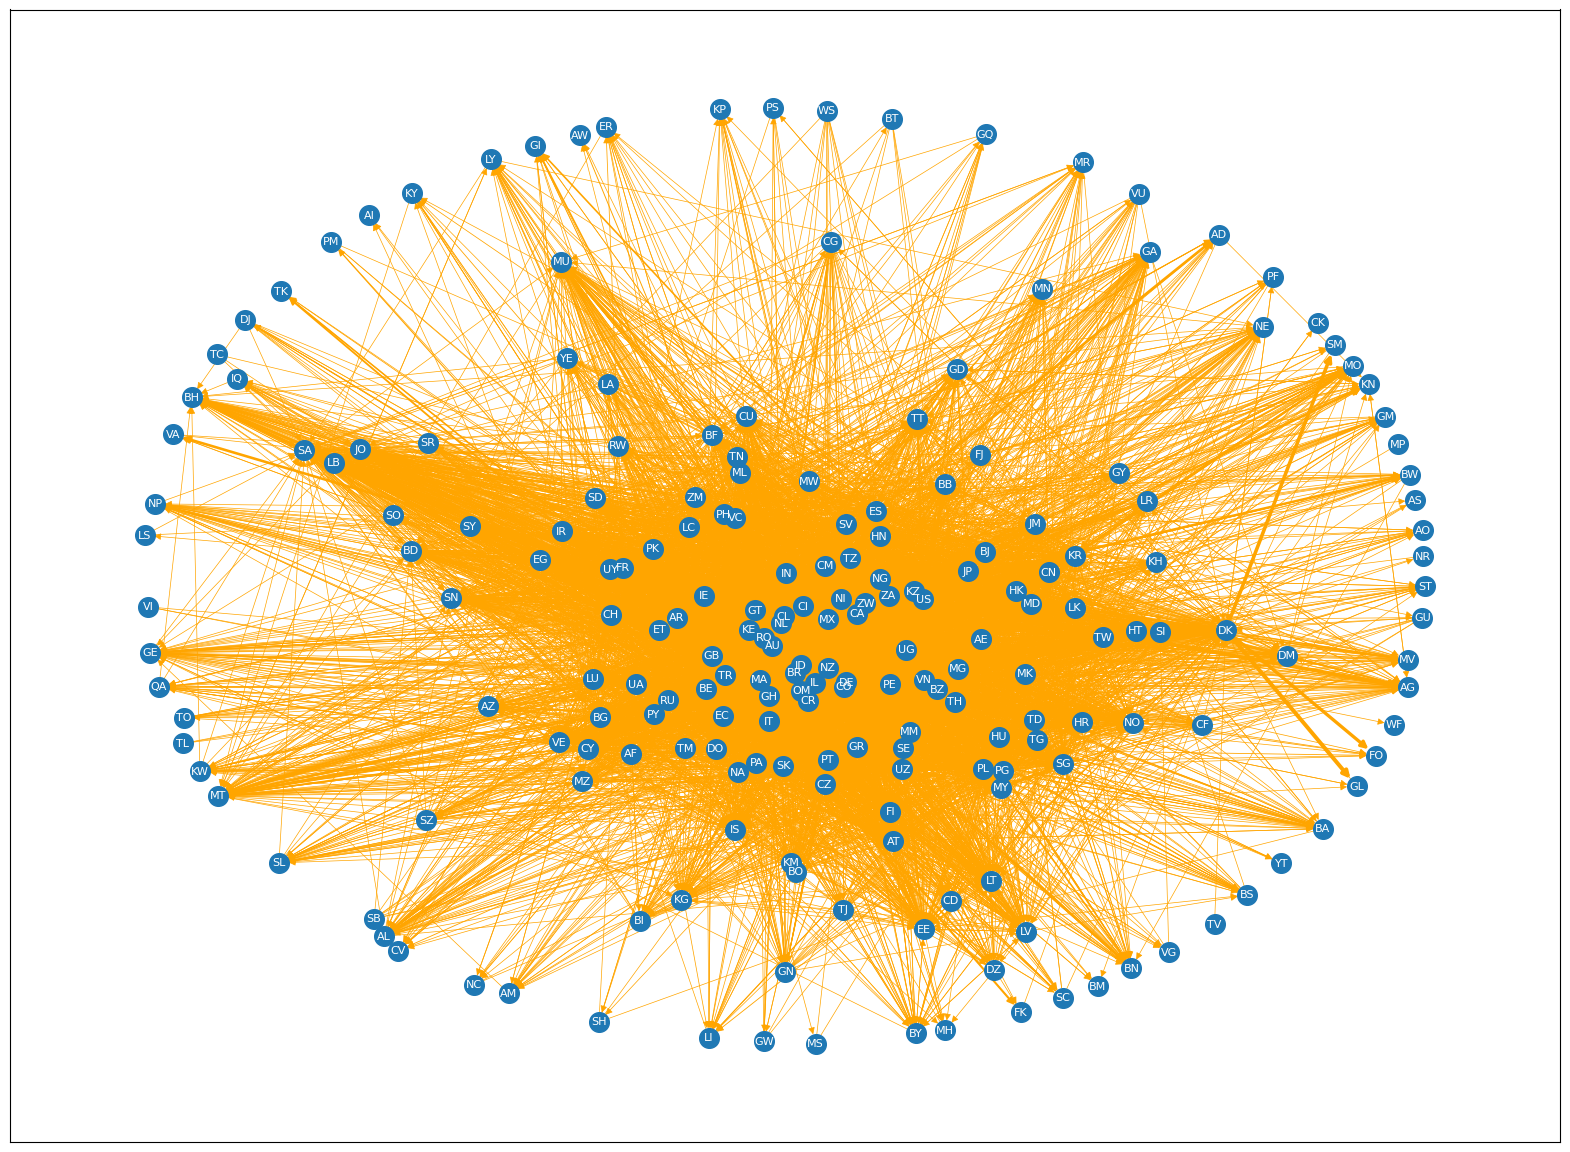

In [ ]:
plt.figure(figsize=(20,15),dpi=100)
edg_color = [G.get_edge_data(u,v)["weight"] for u,v in G.edges()]
m = max(edg_color)
edg_color = [(i/m)*256 + 30 for i in edg_color]
pos = nx.spring_layout(G, k=1000/np.sqrt(G.order()), weight="weight", iterations=1000)
nx.draw_networkx(G, pos=pos, edge_color="orange", edge_cmap=edg_color, width=[i/60 for i in edg_color], font_color="white", font_size=8, node_size=200)
plt.show()

In [3]:
print("Running on whole time and merging to big df...")
metrics_full = {}
df_pop, eu_iso = g.load_population_df()
big_df_col = ["year","month","prod","country"] +  ['edges','nodes','size','degree',
    'degree_perc',
    'out_degree',
    'out_degree_perc',
    'in_degree',
    'in_degree_perc',
    'density',
    'density_adj',
    'clustering',
    'page_rank',
    'vulnerability',
    'in_weight_degree',
    'out_weight_degree',
    'degree_gamma',
    'degree_xmin',
    'in_degree_gamma',
    'in_degree_xmin',
    'out_degree_gamma',
    'out_degree_xmin',
    'in_weight_degree_gamma',
    'in_weight_degree_xmin',
    'out_weight_degree_gamma',
    'out_weight_degree_xmin',
    'out_weight_abs',
    'in_weight_abs']

big_df = pd.DataFrame(columns=big_df_col)
issues = []
for y in tqdm([y for y in range(2001,2021)]):
    # print(y,m)
    df, _ = g.load_filtered_data("complete", save=True, force_reload=False, verbose=False, sorted=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                                years=[y], months=None, product="all", flow="all", declarant_iso="all", partner_iso="all", trade_type="all")
    n4g = g.get_world_countries(df_pop, eu_iso, year=str(y))
    for prod in df.PRODUCT_CPA2_1.unique():
        df4g = df[df.PRODUCT_CPA2_1 == prod]
        t4g = g.extract_table_for_graph(df4g, y=str(y), flow="all", scale_by='population', pop_df=df_pop)
        if t4g.shape[0] < 10:
            issues.append((y,prod,t4g.shape[0]))
            # print(y,m,prod,t4g.shape[0])
        coord, metrics, G = g.makeGraph(t4g, tab_nodes=None, weight_flag=True, criterio="VALUE_IN_EUROS")
        nx.write_gexf(G,f"data-samples/graphs/complete/complete_y{y}_p{prod}.gexf")
        x = metrics.reset_index().to_dict()
        x["year"] = str(y)
        x["month"] = "-"
        x["prod"] = prod
        big_df = pd.concat([big_df,pd.DataFrame(x,columns=big_df_col)],axis=0)
        metrics_full[f"{y}_cpa_{prod}"] = metrics #.sort_values("degree",ascending=False)
    # break
print(issues)
pickle.dump(metrics_full,open("./data-samples/manual/metrics/metrics_complete_V.pickle","wb"))
big_df.to_parquet("./data-samples/manual/metrics/metrics_complete_V.parquet")


Running on whole time and merging to big df...


  0%|          | 0/20 [00:00<?, ?it/s]

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.7/dist-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in double_scalars
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/usr/local/lib/python3.7/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in double_scalars
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan


  0%|          | 0/1 [00:00<?, ?it/s]

[(2005, 'FF', 4)]


In [ ]:
def load_filtered_data(table, save=False, verbose=1, force_reload=False, sorted=True, **params):
    """"
    load_filtered_data("full", save=True, force_reload=True, columns=g.full_columns, types=g.full_types, 
                        group_by_prod_code=True, n_digits=2, years=[2012], months=None, product="all", 
                        flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

    table: str
    save: bool
    types: dict(type)
    columns: list
    group_by_prod_code: bool 
    n_digits: int
    years: list(int)
    months: list(int) | None | "all"
    product: "all" | list(str) 
    flow: 1 | 2 | "all"
    trade_type: "I" | "E" | "all"
    declarant_iso: str | "all"
    partner_iso: str | "all"

    Returns
        (pd.DataFrame, str)
    """
    
    if verbose:
        print("loading",table,end=": ")

    def get_params_str_hash(params):
        str_params = {x:params[x] for x in params if x != "types"}
        # str_params = params
        # return str(str_params).replace("{","").replace("}","").replace("': ","_").replace("[","").replace("]","").replace(", ","_").replace("'","").replace("<class ","").replace(">","")
        return hashlib.sha256(str(str_params).encode("UTF_8")).hexdigest()

    def group_by_prod_code(table,**params):
        df = table.copy()
        column = df.columns[0]
        df[column] = df[column].str[:params["n_digits"]]
        return df.groupby(params["columns"][:-2],as_index=False).sum()
    
    if not force_reload and os.path.exists(f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet"):
        if not os.path.exists(f"./data-samples/manual/{table}/"):
            os.makedirs(f"./data-samples/manual/{table}/")
        if verbose:
            print("loading existing...",end=" ")
        df = pd.read_parquet(f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet")
        if verbose:
            print("Table loaded")
        return df, None
    else:
        prod_code_df = params["columns"][0]

        def build_filters(df,params,table,name,prod_code_df):
            filters = pd.Series([True for i in range(df.shape[0])])
            if isinstance(params["product"],list):
                filter_prod = ~filters.copy()
                not_f = []
                for p in params["product"]:
                    mask = (df[prod_code_df] == p)
                    if not mask.any():
                        not_f.append(p)
                    filter_prod = filter_prod | mask
                if verbose==2 and len(not_f) > 0:
                    print(','.join(not_f),f"not found in {table}{name}",end=", ")
                filters = filters & filter_prod
            elif params["product"] != "all":
                mask = (df[prod_code_df] == params["product"])
                if verbose==2 and not mask.any():
                    print(f"{params['product']} not found in {table}{name}",end=", ")
                filters = filters & mask
            if params["flow"] != "all":
                filters = filters & (df.FLOW == params["flow"])
            if table == "full" and params["trade_type"] != "all":
                filters = filters & (df.TRADE_TYPE == params["trade_type"])
            if isinstance(params["declarant_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["declarant_iso"]:
                    mask = (df["DECLARANT_ISO"] == p)
                    if verbose==2 and not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["declarant_iso"] != "all":
                mask = (df["DECLARANT_ISO"] == params["declarant_iso"])
                if verbose==2 and not mask.any():
                    print(f"{params['declarant_iso']} not found in {table}{name}",end=", ")
            if isinstance(params["partner_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["partner_iso"]:
                    mask = (df["PARTNER_ISO"] == p)
                    if verbose==2 and not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["partner_iso"] != "all":
                mask = (df["PARTNER_ISO"] == params["partner_iso"])
                if verbose==2 and not mask.any():
                    print(f"{params['partner_iso']} not found in {table}{name}",end=", ")
            
            if verbose==2 and not filters.any():
                print(f"\n\tempty df for {table}{name}")

            return filters

        if table not in ["full","tr","tr_intra_","wto","complete"]:
            raise Exception("table not valid")
        df = pd.DataFrame(columns=params["columns"])
        for y in tqdm(params["years"],leave=False):
            if verbose:
                print(y,end=" ")
            if table == "complete":
                df_com = pd.read_parquet(f"./data-samples/full/Years/full{y}52.parquet",columns=params["columns"])
                df_wto = pd.read_parquet(f"./data-samples/wto/Years/wto{y}52.parquet",columns=params["columns"])
                df_y = g.combine_sources(df_com,df_wto)
                # return df_com, df_wto, df_y
                if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                    # df_y_filtered = group_by_prod_code(df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)],**params)
                    df_y_filtered = group_by_prod_code(df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"]),**params)
                    # return df_y_filtered
                else:
                    df_y_filtered = df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"])
                df = pd.concat([df,df_y_filtered])
            else:
                if params["months"] is None:
                    df_y = pd.read_parquet(f"./data-samples/{table}/Years/{table}{y}52.parquet",columns=params["columns"])
                    if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                        df_y_filtered = group_by_prod_code(df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"]),**params)
                    else:
                        df_y_filtered = df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"])
                    df = pd.concat([df,df_y_filtered])
                    del df_y, df_y_filtered
                elif params["months"] == "all":
                    for m in tqdm(range(1,13),leave=False):
                        # if verbose:
                        #     print(str(m),end=" ")
                        df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                        if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                            df_y_filtered = group_by_prod_code(df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"]),**params)
                        else:
                            df_y_filtered = df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"])
                        df = pd.concat([df,df_y_filtered])
                    del df_ym, df_y_filtered
                else:
                    for m in params["months"]:
                        if verbose:
                            print(str(m),end=" ")
                        df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                        if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                            df_y_filtered = group_by_prod_code(df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"]),**params)
                        else:
                            df_y_filtered = df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"])
                        df = pd.concat([df,df_y_filtered])
                    del df_ym, df_y_filtered
        if df.shape[0] == 0:
            if verbose:
                print("\n\tEmpty table")
            return df
        else:
            if sorted:
                df_out = df.groupby(params["columns"][:-2],as_index=False).sum().sort_values(params["columns"][-1],ascending=False).reset_index(drop=True)
            else:
                df_out = df.groupby(params["columns"][:-2],as_index=False).sum().reset_index(drop=True)
            str_save = f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet"
            if save:
                try:
                    df_out.to_parquet(str_save)
                    if verbose:
                        print(",\t Table loaded")
                    return df_out.astype(params["types"]), str_save
                except:
                    if verbose:
                        print("\nFailed saving",end="")
                        print(", Table loaded")
                    return df_out.astype(params["types"]), str_save
            else:
                return df_out.astype(params["types"]), str_save
          

In [ ]:
df_com, df_wto, df_y = load_filtered_data("complete", save=True, force_reload=False, verbose=False, sorted=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                                years=[2007], months=None, product="all", flow="all", declarant_iso="all", partner_iso="all", trade_type="all")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_y = g.combine_sources(df_com,df_wto)

In [ ]:
df_y[(df_y == "").any(axis=1)]

,PRODUCT_CPA2_1,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG
6675032,2825,RO,ES,1,200752,742.0,


In [ ]:
df_full = load_filtered_data("full", save=True, force_reload=False, verbose=False, sorted=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                                years=[2007], months=None, product="all", flow="all", declarant_iso="all", partner_iso="all", trade_type="all")

In [ ]:
df_full = pd.read_parquet("data-samples/full/Years/full200752.parquet")[g.full_columns]

In [ ]:
df_try = pd.concat([df_full[(df_full == "").any(axis=1)] for i in range(10)])

In [ ]:
df_try = df_full.loc[6675030:6675040]

In [ ]:
df_try.loc[(df_try == "").any(axis=1),"QUANTITY_IN_KG"] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
df_try.loc[df_try[(df_try == "").any(axis=1)].index,"QUANTITY_IN_KG"] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
for y in trange(2007,2021):
    df = pd.read_parquet(f"data-samples/full/Years/full{y}52.parquet")
    l = df[df.QUANTITY_IN_KG == ""].index.to_list()
    df.loc[l,"QUANTITY_IN_KG"] = 0
    # df.loc[l,"QUANTITY_IN_KG"]
    df.astype(g.full_types).to_parquet(f"data-samples/full/Years/full{y}52.parquet")

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
df[df.QUANTITY_IN_KG == ""]

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,TRADE_TYPE,PRODUCT_NC,PRODUCT_SITC,PRODUCT_CPA2002,PRODUCT_cpa2008,PRODUCT_CPA2_1,PRODUCT_BEC,PRODUCT_SECTION,FLOW,STAT_REGIME,SUPP_UNIT,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,SUP_QUANTITY
6675032,66,RO,11,ES,I,84151010,74151,2923,2825,2825,610,16,1,1,,200752,742,,
